In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# 修改默认字体
font = {'family': 'serif',
        'serif': 'Times New Roman',
        'weight': 'normal'}
plt.rc('font', **font)
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签

In [3]:
# 定义全局变量
miu = 0.011
g = 9.8
m_ren=70
m_che=7
m = m_ren + m_che
r = 0.66   # 车轮半径
c = 0.25   # 一个未知系数
w_shoulder = 0.46    # 肩宽
l_leg = 1.0        # 腿长
s = w_shoulder * l_leg   # 人加车正对面积
rou = 1.205   # kg/m^3

sigma1 = 42 # 表示有氧呼吸的速率  # sigma2表示无氧呼吸的速率，以函数形式给出

W_max = 2403.5e3  # 最大的功率
alpha = 0.1   # 一个比率

In [4]:
# 阻力函数
f1 = miu*m*g/(2*r)

def f2(v):
    return 1/2*c*rou*s*v*v

def f_zu(v):
    return f1 + f2(v)

def sigma2(P):       # P是人体功率， v是当前速度
    if P < sigma1:
        return 0
    else:
        return P - sigma1 

# P功率最大维持时间
def T(P):
    return W_max / ( (2.38969595e-06*(P-sigma1)**3+3.2) *P)

# 添加k的时间
def T_new(P,k):
    return W_max / ( (2.38969595e-06*( (P-sigma1)/(1-k) )**3+3.2) *( (P-sigma1)/(1-k)+sigma1) )

# 要休息的时间
def T_rest(P):
    if P < 188:
        return 600 * 0.5
    else:
        return ((P-139)*(-9.76562500e-04*P + 1.18359375e+00))/97 * T(P) * 0.5


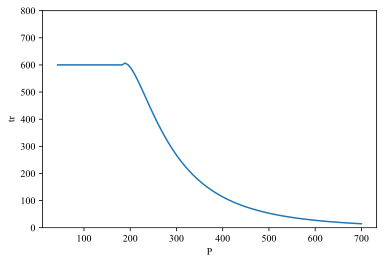

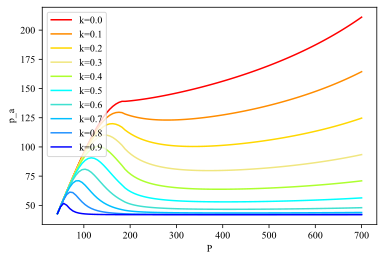

In [5]:
k_test = np.linspace(0,0.9,10)
p_test = np.linspace(43,700,100)

yy=[]
color=["#ff0000","#ff8c00","#ffd700","#f0e680","#adff2f","#00ffff","#40e0d0","#00bfff","#1e90ff","#0000ff","#191970"]
for i in range(len(k_test)):
    t_new = T_new(p_test,k_test[i])
    yy.append(t_new)

# 要休息的时间
tr=((p_test-139)*(-9.76562500e-04*p_test + 1.18359375e+00))/97 * yy[0]
for i in range(100):
    if p_test[i]<188:
        tr[i]=600
plt.plot(p_test,tr)
plt.ylabel("tr")
plt.xlabel("P")
plt.ylim(0,800)
plt.show()

# 平均功率
for i in range(10):
    t=yy[i]
    p_a = (42*tr + p_test * t) / (tr + t)
    plt.plot(p_test,p_a,color=color[i],label="k="+str(format(k_test[i], '.1f')))

plt.ylabel("p_a")
plt.xlabel("P")
plt.legend()
plt.show()             

In [6]:
# 初始化挡位
dangwei=[]
for i in range(1000):
    if i%2:
        dangwei.append(2)
    else:
        dangwei.append(5)

p_dw=[]
pp_temp=np.asarray([42,100,200,300,400,500,600,700])
# 每个挡位能坚持的时间
p_dw_time=[]
for i in range(len(pp_temp)):
    p_dw_time.append(T(pp_temp[i]))


for i in range(10):
    k = 0.1 * i
    p_dw.append( np.round((pp_temp-42)*(1-k) + 42,0) )
print(p_dw)
# 显示k=0.5时， 4档的持续功率
k=0.5
dw=4
print(p_dw[int(k/0.1)][dw])
print(p_dw_time)

[array([ 42., 100., 200., 300., 400., 500., 600., 700.]), array([ 42.,  94., 184., 274., 364., 454., 544., 634.]), array([ 42.,  88., 168., 248., 328., 408., 488., 568.]), array([ 42.,  83., 153., 223., 293., 363., 433., 503.]), array([ 42.,  77., 137., 197., 257., 317., 377., 437.]), array([ 42.,  71., 121., 171., 221., 271., 321., 371.]), array([ 42.,  65., 105., 145., 185., 225., 265., 305.]), array([ 42.,  59.,  89., 119., 149., 179., 209., 239.]), array([ 42.,  54.,  74.,  94., 114., 134., 154., 174.]), array([ 42.,  48.,  58.,  68.,  78.,  88.,  98., 108.])]
221.0
[17883.184523809523, 6555.730029057573, 951.8279300902009, 181.09770056306368, 53.247472851185485, 20.650163634770653, 9.574436169531877, 5.0198322812544625]


In [13]:
# 初始化  目前不需要休息时间
flag=1      #  判断结束后退出的标志
j = 0  # 标志挡位改变的标记

# 转弯矩阵
turn = [[1000,2000],[5000,7000]]
v_limit = 1

t=[]    # 时间
v=[]    # 速度
p=[]    # 功率
x=[]    # 路程
f=[]    # 阻力
k=[]    # 记录取整的k
E=[]    # 消耗的能量
kk=[]   # 记录未取整的k
sigma=[]

# 添加初始值
kk.append(0)
t.append(0)
v.append(0)
k.append(0)
p_new = p_dw[int(k[0]/0.1)][dangwei[j]]
p.append(p_new)
x.append(0)
f.append(f1)

E.append(0)

sigma.append(sigma2(p[0]))

T_P = round(T_new(p[0],k[0]))
stay = T_P  # 该挡位可持续时间

# 开始迭代
for i in range(1,150000):
    t_temp = t[i-1]+1;  t.append(t_temp)
    # 确定此时的P
    if i<stay:
        p_temp = p_dw[int(k[i-1]/0.1)][dangwei[j]]
        # k_temp = (k[i-1]); k.append(k_temp//0.1 /10); 
        # kk.append(k_temp)
    elif i==stay:
        p_temp = p_dw[int(k[i-1]/0.1)][dangwei[j]]
        p_new = p_dw[int(k[i-1]/0.1)][dangwei[j+1]]
        j+=1  # 下次取下一个挡位
        T_P= round(T_new(p_new,k[i-1]))
        stay = stay + T_P
    k_temp = (E[i-1] / 2e6); 
    if k_temp < 0.991:
        k.append(k_temp//0.1 /10); 
    else:
        k.append(0.99)

        # kk.append(k_temp)

    p.append(p_temp)

    v_temp = math.sqrt( 2*(p[i-1]-f[i-1]*v[i-1])/m + v[i-1]**2 )
    x_temp = x[i-1] + (v[i-1] + v_temp)/2

    if len(turn)>0:
        if x_temp>=turn[0][1]:
            del turn[0]
        elif x_temp >= turn[0][0] and x_temp <turn[0][1]:
            v_temp = v_limit
            x_temp = x_temp = x[i-1] + (v[i-1] + v_temp)/2

    v.append(v_temp)
    x.append(x_temp)

    f_temp = f_zu(v[i]) + 5;    f.append(f_temp)
    E_temp = E[i-1] + p[i-1] - sigma1;  E.append(E_temp)
    

    
    print('时刻i: ', i, ' stay=',stay, ' t=',t[i],' p=',p[i],' v=',v[i],' x=',x[i],' f=',f[i],' E=',E[i],' k=',k[i])
    # print('时刻i: ', i, ' stay=',stay, ' dw=',dangwei[j],' p=',p[i],' x=',x[i],' k=',k[i])

    if(x_temp>140000 and flag):
        print(t_temp/3600,j)
        flag = 0
        break

时刻i:  1  stay= 21  t= 1  p= 500.0  v= 3.603749850782236  x= 1.801874925391118  f= 12.188170995670998  E= 458.0  k= 0.0
时刻i:  2  stay= 21  t= 2  p= 500.0  v= 4.983288646033803  x= 6.0953941737991375  f= 13.008961303829189  E= 916.0  k= 0.0
时刻i:  3  stay= 21  t= 3  p= 500.0  v= 6.011351753748745  x= 11.592714373690411  f= 13.792130677535251  E= 1374.0  k= 0.0
时刻i:  4  stay= 21  t= 4  p= 500.0  v= 6.8534570336107885  x= 18.025118767370177  f= 14.542758430407298  E= 1832.0  k= 0.0
时刻i:  5  stay= 21  t= 5  p= 500.0  v= 7.5741733978581784  x= 25.23893398310466  f= 15.263225746445073  E= 2290.0  k= 0.0
时刻i:  6  stay= 21  t= 6  p= 500.0  v= 8.206848002161538  x= 33.129444683114514  f= 15.95500957015609  E= 2748.0  k= 0.0
时刻i:  7  stay= 21  t= 7  p= 500.0  v= 8.771449103001679  x= 41.618593235696125  f= 16.619197136443095  E= 3206.0  k= 0.0
时刻i:  8  stay= 21  t= 8  p= 500.0  v= 9.28110894319792  x= 50.64487225879593  f= 17.256688132877873  E= 3664.0  k= 0.0
时刻i:  9  stay= 21  t= 9  p= 500.0  v=

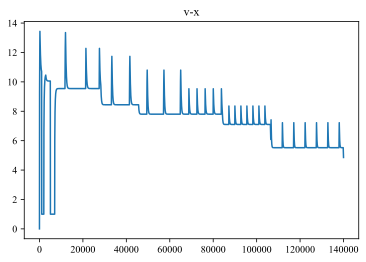

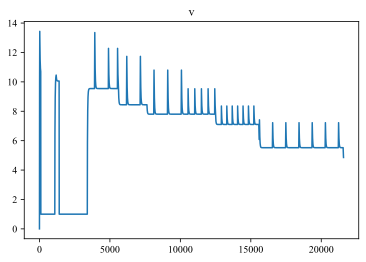

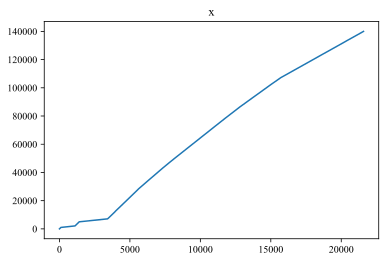

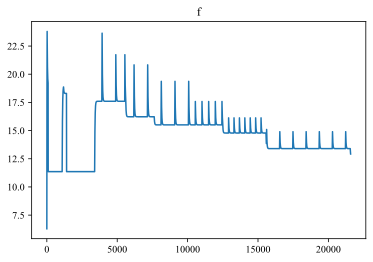

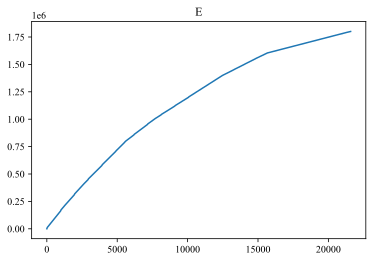

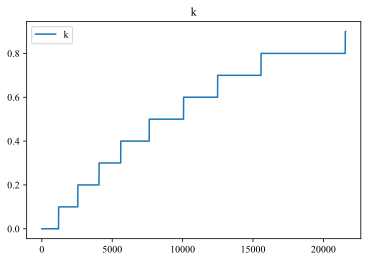

In [15]:
# 绘图
plt.plot(x,v)
plt.title("v-x")
plt.show()


plt.plot(t,v)
plt.title("v")
plt.show()

plt.plot(t,x)
plt.title("x")
plt.show()

plt.plot(t,f)
plt.title("f")
plt.show()

plt.plot(t,E)
plt.title("E")
plt.show()

plt.plot(t,k,label='k')
# plt.plot(t,kk,label="k'")

plt.title("k")
plt.legend()
plt.show()
